In [1]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import os
import pandas as pd

In [2]:
# Count number of ML models
# WORKING HERE: Set path to ml_models output directory
ml_models_path = "/pw/bkup/tmp/dynamic-learning-rivers/ml_models/"
number_models = 0

for file in os.listdir(ml_models_path):
    if(file.startswith("sl_")):
        number_models += 1

In [3]:
fpi_results = pd.DataFrame()
fpi_results_std = pd.DataFrame()

for i in range(number_models):
    fpi_results_path = f"{ml_models_path}sl_{i}/sl_fpi_results_df"
    fpi_results_csv = pd.read_csv(fpi_results_path)
    
    #print(fpi_results_csv)
    
    # Initialize storage for features in this model
    feature_list = []
    importance_list = []
    uncertainty_list = []
    for row in range(len(fpi_results_csv)):
        for feature in fpi_results_csv.loc[row,"Feature"].split(','):
            feature_list.append(feature)
            importance_list.append(fpi_results_csv.loc[row,"Avg_Ratiostack0"])
            uncertainty_list.append(fpi_results_csv.loc[row,"Std_Ratiostack0"])
    
    # For each feature, extract its value from the dataframe where features
    # are grouped and put that value in the dataframe where features are separate
    #for feature in feature_list.
    fpi_results_one_sl = pd.DataFrame(feature_list,columns=pd.Index(['Feature']))
    fpi_results_one_sl.insert(1,"FPI_Ratio_"+str(i),importance_list,allow_duplicates=False)
    
    # Update the feature-by-feature dataframe with the feature_list as an Index
    # Now data can be accessed directly by feature name. Drop the Feature column
    # since it is now the index.
    fpi_results_one_sl.index = list(fpi_results_one_sl["Feature"])
    fpi_results_one_sl.pop("Feature")
    
    # Now data can be accessed directly by feature name, e.g.:
    # fpi_results_one_sl.loc['sgr_dk_rav','FPI_Ratio']
    
    # Do exactly the same thing for the standard deviations associated with each FPI ratio
    fpi_results_one_sl_std = pd.DataFrame(feature_list,columns=pd.Index(['Feature']))
    fpi_results_one_sl_std.insert(1,"FPI_Ratio_"+str(i),uncertainty_list,allow_duplicates=False)
    fpi_results_one_sl_std.index = list(fpi_results_one_sl_std["Feature"])
    fpi_results_one_sl_std.pop("Feature")
    
    # Append the results to overall 
    if i == 0:
        fpi_results = fpi_results_one_sl
        fpi_results_std = fpi_results_one_sl_std
    else:
        fpi_results = fpi_results.join(fpi_results_one_sl, validate="1:1")
        fpi_results_std = fpi_results_std.join(fpi_results_one_sl_std, validate="1:1")
    
# TODO: if there's a variable (feature) that doesn't show up in every
# model, when we divide by the number of models and we are potentially
# severely diluting the average.
#avg_fpi_results = fpi_results.iloc[:, 1:].div(number_models)
# Bypass this issue by scatter plot the ratios from each submodel along with the averages.

# Error bars: The std of the FPI iterations are usually very small compared to
# the ratios themselves (~10%) and the scatter between SuperLearners.  Find the 
# max value over the whole data set for context:
std_over_avg = fpi_results_std/fpi_results
print('Maximum std/avg FPI ratio over all models: '+str(std_over_avg.max().max()))

Maximum std/avg FPI ratio over all models: 0.09752378704846765


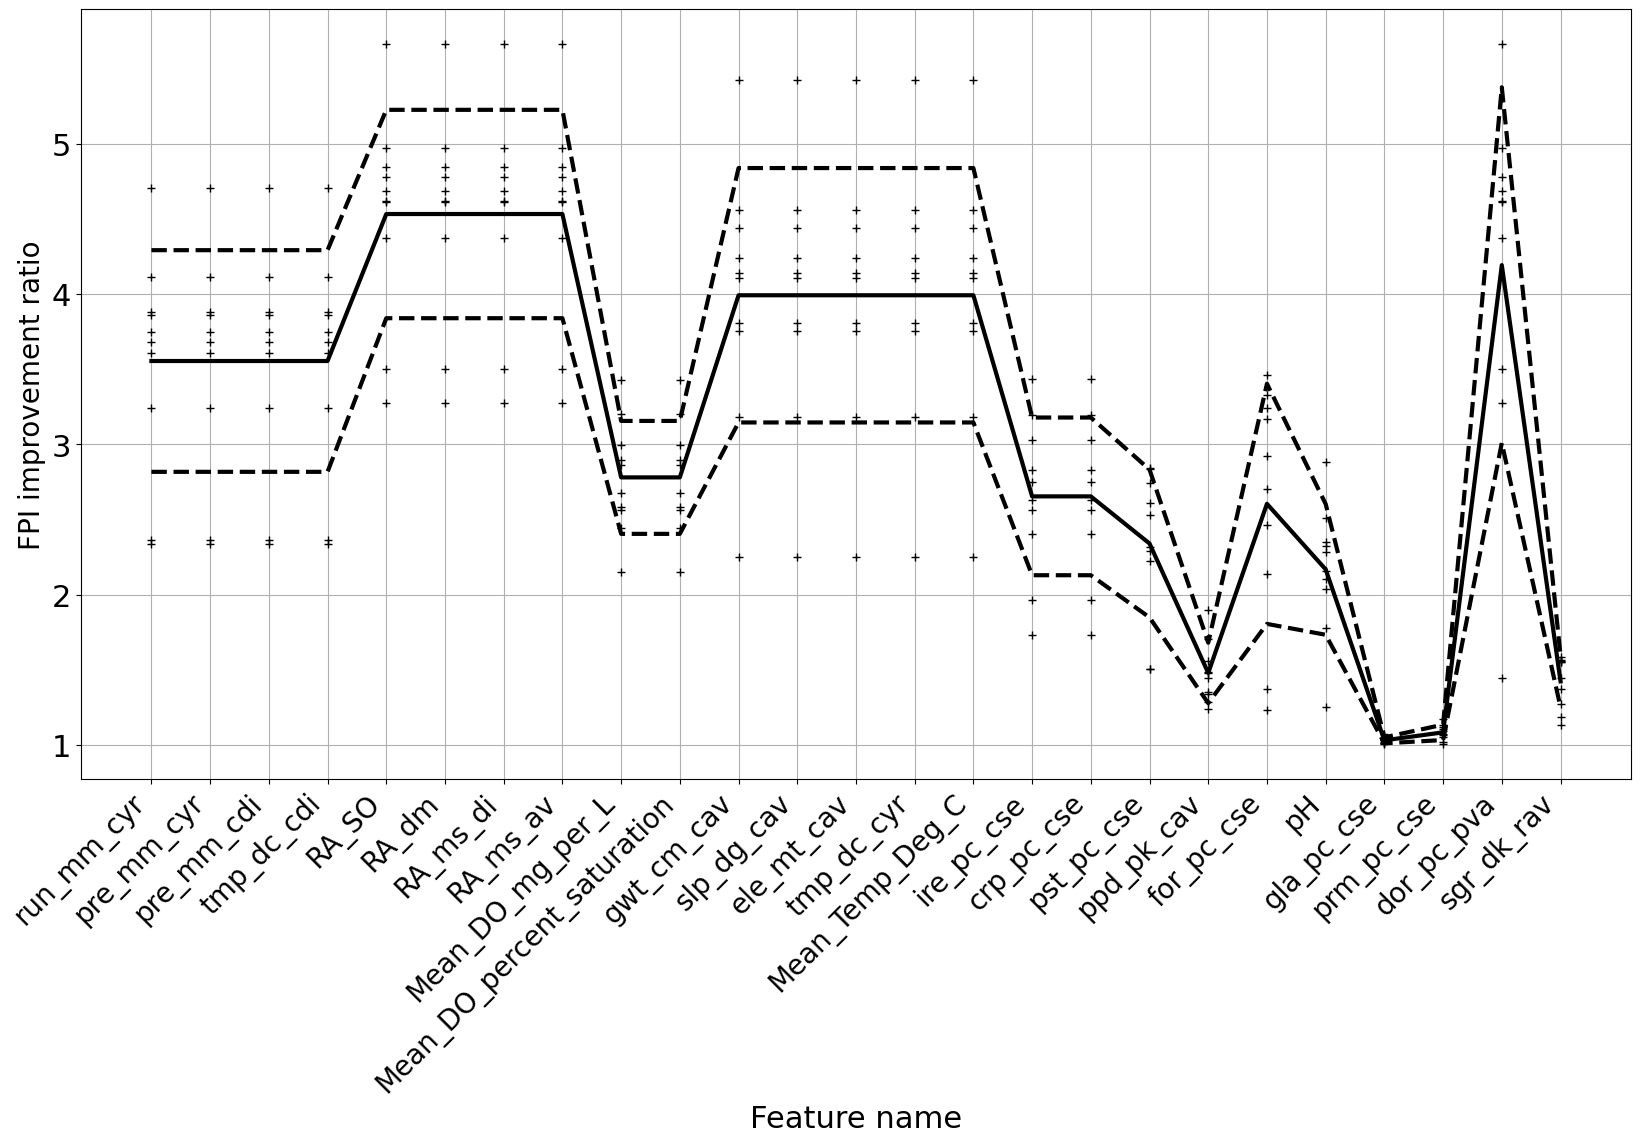

In [10]:
fig, ax = plt.subplots(figsize=(20,10))

# Rotate feature names so they are legible in plot
plt.xticks(rotation=45, ha='right', fontsize=20)

ax.plot(fpi_results,'k+')
ax.plot(fpi_results.mean(axis=1),'k',linewidth=3)
ax.plot(fpi_results.mean(axis=1)+fpi_results.std(axis=1),'k--',linewidth=3)
ax.plot(fpi_results.mean(axis=1)-fpi_results.std(axis=1),'k--',linewidth=3)
ax.grid()
plt.ylabel('FPI improvement ratio', fontsize=20)
plt.xlabel('Feature name')
plt.savefig('tmp.png')

This cell consolidates the results of the model-by-model FPI results.  To save computational time, FPI is only computed for the top best performing submodels in the SL stacked ensemble, not all submodels. For now, do not use this additional information since it is difficult to interpret. The focus, above, is on the whole SL ensemble FPI.

In [ ]:
fpi_results = pd.DataFrame()

for i in range(number_models):
    model_fpi_results_path = f"{ml_models_path}sl_{i}/model_fpi_results_df"
    model_fpi_results = pd.read_csv(model_fpi_results_path)

    # "Feature" column has comma-separated strings that can be in different orders
    # Alphabetize the comma-separated strings
    delimiter = ","
    
    for row in range(len(model_fpi_results)):
        feature = model_fpi_results.loc[row, "Feature"]
        alphabetized_feature = delimiter.join(sorted(feature.split(delimiter), key=str.casefold))
        model_fpi_results.loc[row, "Feature"] = alphabetized_feature
        
    if i == 0:
        fpi_results = model_fpi_results
    else:
        fpi_results = pd.concat([fpi_results, model_fpi_results])

fpi_results = fpi_results.groupby(["Feature"]).mean()
fpi_results

In [ ]:
fpi_results.plot()
plt.xticks(rotation=45, ha='right')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.savefig("line_model_fpi_per_variable.png")

In [ ]:
fpi_results.boxplot()
plt.xticks(rotation=45, ha='right')
plt.draw()
plt.savefig("boxplot_variable_fpi_per_model.png")

In [ ]:
fpi_results.T.boxplot()
plt.xticks(rotation=45, ha='right')
plt.savefig("boxplot_model_fpi_per_variable.png")